In [159]:
from tqdm import tqdm
import json
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet as wn
from copy import deepcopy
import re
import math
import spacy
from spacy import displacy
import en_core_web_md

In [38]:
FILTER_SPOILERS = True

In [176]:
book_id = "3"
# harry potter and the sorcerer's stone = 3
# twilight = 41865
# the expanse = 8855321
# eric = 64218
# guards guards = 64216

In [179]:
def find_book(book_id):
    with open("data/goodreads_books_fantasy_paranormal.json") as f:
        for line in tqdm(f):
            book = json.loads(line)
            if book["book_id"] == book_id:
                return book
    return None

book = find_book(book_id)

173961it [00:13, 12832.39it/s]


In [187]:
title = book["title"].split("(", 1)[0]
series = book["title"].split("(", 1)[1].rstrip("0123456789#), ")
print(title)
print(series)

Harry Potter and the Sorcerer's Stone 
Harry Potter


In [177]:
def get_reviews_from_book_id(book_id):
    reviews = []
    with open("data/goodreads_reviews_fantasy_paranormal.json") as f:
        for line in tqdm(f):
            review = json.loads(line)
            if review["book_id"] == book_id:
                reviews.append(review)
    return reviews

reviews = get_reviews_from_book_id(book_id)

3424641it [00:56, 60317.90it/s]


In [36]:
len(reviews)

8458

In [39]:
def filter_spoilerous(reviews):
    return [review for review in reviews if "spoiler" not in review["review_text"]]

if FILTER_SPOILERS:
    reviews = filter_spoilerous(reviews)

In [40]:
len(reviews)

8357

In [41]:
def get_ids():
    ids = set()
    with open("data/goodreads_reviews_fantasy_paranormal.json") as f:
        for line in tqdm(f):
            review = json.loads(line)
            ids.add(review["book_id"])
    return ids

In [42]:
text = " ".join(review["review_text"] for review in reviews)
tokenized = nltk.word_tokenize(text)
possed = nltk.pos_tag(tokenized)

In [43]:
lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(word, pos.lower()[0] if pos.lower()[0] in "nvars" else "n").lower() for word, pos in possed]

In [157]:
def sentimental_words(lemmatized, total, treshold):
    sia = SentimentIntensityAnalyzer()
    fd = nltk.FreqDist(lemmatized)
    
    result = []
    for val, freq in fd.most_common():
        scores = sia.polarity_scores(val)
        if abs(scores["compound"]) > treshold:
            result.append((val, freq, scores))
        if len(result) >= total:
            break
    return result

In [158]:
sentimental_words(lemmatized, 20, 0.6)

[('love', 3156, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('great', 1123, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('best', 544, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('awesome', 261, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('evil', 206, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6597}),
 ('kill', 132, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6908}),
 ('perfectly', 67, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('greatest', 59, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6369}),
 ('hell', 51, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6808}),
 ('worst', 39, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6249}),
 ('masterpiece', 32, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6249}),
 ('abuse', 29, {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.6369}),
 ('lovable', 27, {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.6124}),
 ('dead', 26,

In [48]:
nlp = en_core_web_md.load()
nlp.max_length = len(text)

In [160]:
print("chars", len(text))
print("words", len(text.split()))

chars 2894093
words 532812


In [51]:
doc = nlp(text)

In [189]:
ents = [ent for ent in doc.ents if ent.label_ in ["PERSON", "WORK_OF_ART"]]

In [199]:
def no_unsquishables(needle, haystack, unsquishables):
    for h in haystack:
        if h in unsquishables and h not in needle:
            return False
    return True

def is_word_aware_infix(needle, haystack, unsquishables):
    needle = re.split("[^a-zA-Z]+", needle.lower())
    haystack = re.split("[^a-zA-Z]+", haystack.lower())
    for i in range(len(haystack) - len(needle) + 1):
        if needle == haystack[i:i+len(needle)] and no_unsquishables(needle, haystack, unsquishables):
            return True        
    return False

def contained_in(needle_half, haystack, unsquishables):
    result = set()
    for hay in haystack:
        if needle_half != hay and is_word_aware_infix(needle_half, hay, unsquishables):
            result.add(hay)
    return result

def propagate(mapping):
    for from_, to_ in mapping.items():
        current = mapping[from_]
        stack = [from_]
        while current != mapping[to_]:
            stack.append(current)
            current = mapping[to_]
        for item in stack:
            mapping[item] = current
    return mapping

def squish(values, unsquishables=set(), unremapables=set()):
    unprocessed = set(values)

    mapping = {val:val for val in values}
    for val in values:
        if val not in unprocessed:
            continue
        for con in contained_in(val, unprocessed, unsquishables):
            if not any(is_word_aware_infix(con, word, unsquishables) for word in unremapables) or con.lower() == val.lower():
                mapping[con] = val
            unprocessed.remove(con)
        
    return propagate(mapping)

def squish_ents(people, count=20, unremapables=set()):
    fdp = nltk.FreqDist(ent.text for ent in people)
    names = [p[0] for p in fdp.most_common(count)]
    return squish(names, unremapables=unremapables)

names_mapping = squish_ents(ents, unremapables={title, series})

In [200]:
names_mapping

{'Harry Potter': 'Harry Potter',
 'Harry': 'Harry',
 'Rowling': 'Rowling',
 'Hogwarts': 'Hogwarts',
 'Ron': 'Ron',
 'J.K. Rowling': 'Rowling',
 'Dumbledore': 'Dumbledore',
 'Hermione': 'Hermione',
 'Voldemort': 'Voldemort',
 'Dursleys': 'Dursleys',
 'Jim Dale': 'Jim Dale',
 'Quidditch': 'Quidditch',
 'Neville': 'Neville',
 'J. K. Rowling': 'Rowling',
 "J.K. Rowling's": 'Rowling',
 'J.K Rowling': 'Rowling',
 'harry potter': 'Harry Potter',
 'Hermione Granger': 'Hermione',
 "Harry Potter's": 'Harry Potter',
 'Ron Weasley': 'Ron'}

In [201]:
def compute_vocab_sentiment(doc):
    sia = SentimentIntensityAnalyzer()
    for word in doc.vocab:
        scores = sia.polarity_scores(word.text)
        doc.vocab[word.text].sentiment = scores["compound"]

compute_vocab_sentiment(doc)

In [205]:
def get_dependent(token, dependencies, passthroughs=[], deep=False, result=None):
#     return [word for word in (token.subtree if deep else token.children) if word.dep_ in dependencies]

# def get_dependent_passthrough(token, dependencies, passthroughs, result = None):
    result = result if result is not None else []
    for child in token.children:
        if child.dep_ in dependencies:
            result.append(child)
        if deep or child.dep_ in passthroughs:
            get_dependent(child, dependencies, passthroughs, deep, result)
    
    return result

In [207]:
def get_what(parent):
    what = []
    if not what:
        what = get_dependent(parent, ["acomp"], ["xcomp"])
    if not what:
        what = get_dependent(parent, ["attr"])
    if not what:
        what = get_dependent(parent, ["pobj"], ["prep"])
    if not what or what[0].pos_ == "PRON":
        return []
    return what


def get_negs(parent, what, old_negs=None):
    negs = []
    if not negs:
        negs = get_dependent(parent, ["neg"])
    if not negs:
        negs = [det for det in get_dependent(what, ["det"]) if det.text.strip().lower() == "no"]
    if not negs:
        return old_negs if old_negs is not None else []
    return negs


def get_mods(what, start=None):
    preps = [what.head] if what.head.dep_ == "prep" and what.head.head == start else []
    mods = get_dependent(
        what,
        ["amod", "compound", "advmod", "nummod", "npadvmod", "pobj", "prep", "poss", "case"],
        ["amod", "compound", "advmod", "nummod", "npadvmod", "pobj", "prep", "poss"],
    )
    mods = [mod for mod in mods if (start is None or mod.i > start.i) and mod.pos_ != "SCONJ"]
    return preps + mods


def get_adj_mods(what, start=None):
    mods = get_mods(what, start)
    return [mod for mod in mods if mod.pos_ in ["ADJ", "NOUN"] and mod.i < what.i]


def get_description_from_mods(token):
    return [[mod] for mod in get_adj_mods(token)]


def get_description_from_aux(token, aux):
    whats = get_what(aux)
    if not whats:
        return []

    result = []
    negs = get_negs(aux, whats[0])
    while whats:
        if len(whats) > 1:
            result.append(whats)
            break
        
        what = whats[0]
        mods = get_mods(what, aux)
        desc = sorted(negs + mods + [what], key=lambda tok: tok.i)
        result.append(desc)
    
        whats = get_dependent(what, ["conj"])
    
    return result

def get_description(token):
    descs = get_description_from_mods(token)
    if descs:
        return descs

    while token.dep_ == "conj":
        token = token.head

    if token.dep_ == "nsubj" and token.head.pos_ == "AUX":
        return get_description_from_aux(token, token.head)
    return []

def add_description(i, word, key, result, verbose):
    descs = get_description(word)

    parent = word.head if word.head.pos_ == "AUX" else None
    if (verbose == 1 and not descs) or (verbose == 2 and descs) or verbose >= 3:
        print(i, word)
    if verbose >= 2:
        for desc in descs:
            print(" "*len(str(i)), word, parent if parent is not None else "is", *desc)
    if (verbose == 1 and not descs) or (verbose == 2 and descs) or verbose >= 3:
        print(word.sent)
        print()

    old_descs = result.get(key, [])
    old_descs.extend(descs)
    result[key] = old_descs

def get_character_descriptions(people, verbose=0):
    result = {}
    for i, person in enumerate(people):
        if person.text not in names_mapping:
            continue
        word = person.root
        add_description(i, word, names_mapping[person.text], result, verbose)
    
    return result

def get_aspect_descriptions(doc, aspects, verbose=0):
    result = {}
    for i, word in enumerate(doc):
        if word.text not in aspects:
            continue
        add_description(i, word, word.text, result, verbose)

    return result

character_descriptions = get_character_descriptions(ents)
aspect_descriptions = get_aspect_descriptions(doc, ["book", "story", "writing", "characters" "building", "pacing"])

In [208]:
# i = 62 # 1775 # 602, 784
# print(ents[i].sent)
# displacy.render(ents[i].sent)

Harry Potter 420 

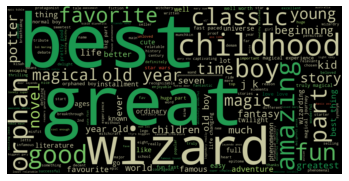

first book in 7 book harry potter series by author j.k rowling
fantastic beginning to one of greatest book series of time
first book in well known series all about wizarding world
first book in rowling 's phenomenal harry potter series
great beginning to wonderful series by j. k. rowling
sweetest most delightful peice of candied literature
first step towards magical world full of adventures
first book in author j. k. rowling 's book series

Rowling 198 

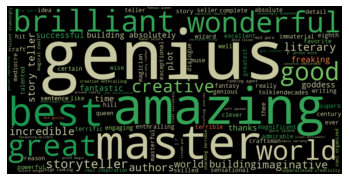

sensational author with her wonderful detail in her world building
really talented writer with unparalleled creativity
just as successful at world building as j.r.r.
closer to lewis ' variety rather than tolkien
one of thee best authors in freaking world
unbelievable talent for first impression
one of world 's most incredible authors

Harry 184 

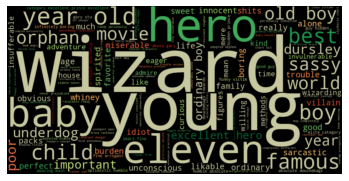

just pitiful helpless preteen with packs of troubles
one of most famous figures in wizarding history
lot younger than one in methods of rationality
bit more whiney in books than in movies
more important than burden of nephew
absolute douchebags towards hermione
never prejudiced against slytherin

Ron 81 

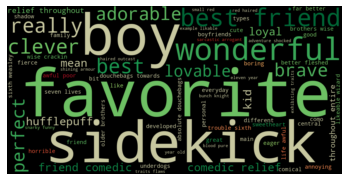

comedic relief throughout entire series for me
absolute douchebags towards hermione
my favorite character with hermione
in shadow of his older brothers
one of my first book boyfriends
eager for their next adventure

Hermione 50 

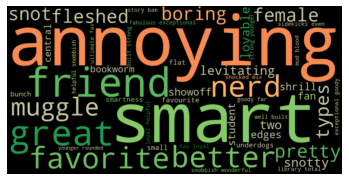

my favorite underdogs of bunch
far better fleshed than harry
wonderful friends to harry
my favourite character
great female character

Dumbledore 46 

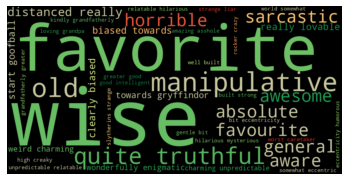

clearly biased towards gryffindor in general
not one of my favourite characters of series
one of my most favorite characters
charming unpredictable relatable
off his rocker crazy old man-

Hogwarts 40 

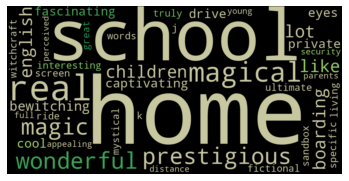

lot like english boarding school
distance from one 's parents
ultimate sandbox for author
place of perceived security
very fascinating place

Voldemort 30 

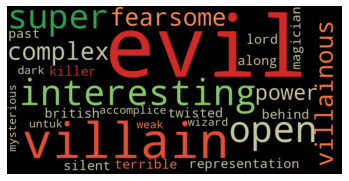

representation of evil 's of british past
one behind it along with his accomplice
not very interesting villain
super complex characters

Jim Dale 29 

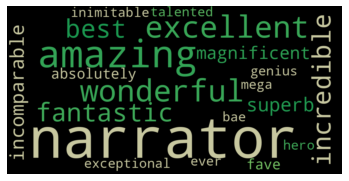

absolutely fantastic narrator
genius narrator for series
one of my fave narrators
mega talented narrator

Dursleys 19 

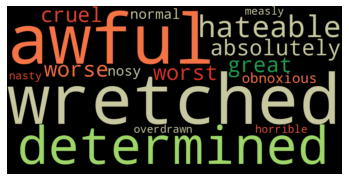

absolutely great characters
little overdrawn
very hateable
determined

Neville 16 

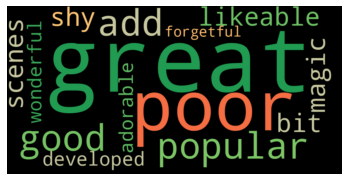

bit more developed
popular character
so likeable
scenes in

book 2901 

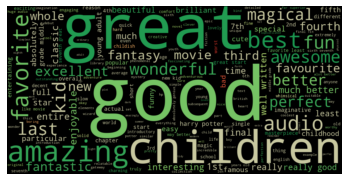

beginning to awesome harry potter series by j.k. rowling
my least favorite book in harry potter series
so much more magical in its original language
surprisingly reflective of childhood psyche
about his first year in wizarding school
great set up for entire potter universe
first one of my favorite story of times
one of greatest displays of imagination
collection of elements from mythology
great example of amazing fantasy book
more unique than set of fingerprints

story 602 

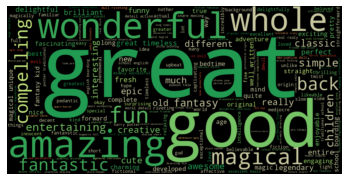

about origins of things of intelligence
not my acceptance letter to hogwarts
so plain spoken so straightforward
excellent basis to magical world
engaging with great twist at end
from third person point of view
more about younger generation
extremely deserving of hype
so compelling good vs. evil

writing 178 

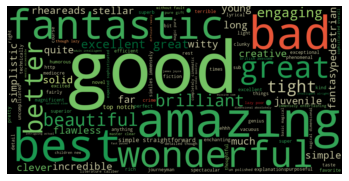

http://rheareads.wixsite.com/rheareads
far more juvenile than rest of novel
simple explanations too long
far superior to most things
more journeyman than master
easily accessible for adult
little light for my taste

pacing 14 

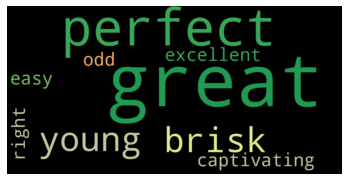

perfect for young reader
captivating
excellent



In [210]:
def word_to_color(word, *args, **kwargs):
    sentiment = doc.vocab[word].sentiment
    import matplotlib as mpl
    import matplotlib.cm as cm

    norm = mpl.colors.Normalize(vmin=-0.8, vmax=0.8)
    cmap = cm.RdYlGn

    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    color = tuple(map(lambda v: int(255*v), m.to_rgba(sentiment)[:3]))
    return color if color != (254, 254, 189) else (200, 200, 160)

def print_descriptions(descs, min_descs=15, extra_stopwords=set()):
    forbidden = set(nltk.corpus.stopwords.words("english")) | extra_stopwords | descs.keys()
    for key, descs in sorted(descs.items(), key=lambda pair: len(pair[1]), reverse=True):
        descs = [" ".join(word.text if word.text != "n't" else "not" for word in desc).lower() for desc in descs]
        if len(descs) < min_descs:
            continue

        print(key, len(descs), end=" ")

        from wordcloud import WordCloud
        import matplotlib.pyplot as plt
    
        wordcloud = WordCloud(
            width=1200,
            height=600,
            stopwords=forbidden,
            collocation_threshold=10,
            color_func=word_to_color
        ).generate(" ".join(descs))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
        print(*sorted(set(descs), key=len, reverse=True)[:int(math.log(len(descs), 2))], sep="\n")
        print()

extra_stopwords = {
    "character", "characters", "writer", "author", "one", "first", "second", "last"
    "whole", "book", "books", "series", "man", "woman", "place", "next", "little",
    "able", "read", "reader"
}

print_descriptions(character_descriptions, min_descs=10, extra_stopwords=extra_stopwords)
print_descriptions(aspect_descriptions, min_descs=10, extra_stopwords=extra_stopwords)

In [144]:
result_dic = {}
for i, word in enumerate(doc):
    key = word.text.lower()
    if abs(word.sentiment) < 0.6:
        continue

    descs = get_description(word)
    if descs:
        for desc in descs:
            old_desc = result_dic.get(key, [])
            old_desc.append(desc)
            result_dic[key] = old_desc
    
    if word.pos_.startswith("V"):
        whats = get_dependent(word, ["dobj"])
        if len(whats) == 1:
            what = whats[0]
            if what.pos_ not in ["PRON"]:
                descs = [sorted(desc + [what], key=lambda word: word.i) for desc in get_description(what)]
                for desc in descs:
                    old_desc = result_dic.get(key, [])
                    old_desc.append(desc)
                    result_dic[key] = old_desc
        continue
    
    desc = []
    negs = []
    current = word
    while current.dep_ in ["amod", "compound", "poss", "advmod"]:
        negs.extend(get_dependent(current, ["neg"]))
        desc.append(current.head)
        current = current.head
    negs.extend(get_dependent(current, ["neg"]))
    
    if desc:
        desc = sorted(negs + desc, key=lambda word:word.i)
#         print(i, word, *desc)
#         print(word.sent)
#         print()

        old_desc = result_dic.get(key, [])
        old_desc.append(desc)
        result_dic[key] = old_desc
        continue
    parent = word.head
    while parent.text.strip() and parent.pos_ != "AUX" and parent.dep_ != "ROOT":
        parent = parent.head
    if parent.pos_ == "AUX":
        subjs = get_dependent(parent, ["nsubj"])
        if subjs and subjs[0].pos_ not in ("PROP", "PRON", "PUNCT", "SCONJ"):
#             print("HERE")
            amods = get_dependent(subjs[0], ["amod", "compound"], deep=True)
            negs = get_dependent(parent, ["neg"])
            desc = negs + sorted(amods + [subjs[0]], key=lambda word: word.i)
#             print(i, word, *desc)
#             print(word.sent)
#             print()

            old_desc = result_dic.get(key, [])
            old_desc.append(desc)
            result_dic[key] = old_desc
        continue
#     print("THERE")
#     print(i, word)
#     print(word.sent)
#     print()

In [145]:
# displacy.render(doc[3973].sent)

In [146]:
print("characters", sum(len(foo[1]) for foo in character_descriptions.items()))
print("aspects", sum(len(foo[1]) for foo in aspect_descriptions.items()))
print("sentimental", sum(len(foo[1]) for foo in result_dic.items()))
print("total", len(list(doc.sents)))
print()

sum_ = sum(len(foo[1]) for foo in character_descriptions.items()) \
+ sum(len(foo[1]) for foo in aspect_descriptions.items()) \
+ sum(len(foo[1]) for foo in result_dic.items())

total = len(list(doc.sents))

print("percentage", f"{sum_ / total * 100:.2f} %")

characters 1117
aspects 3695
sentimental 2500
total 37143

percentage 19.69 %


In [147]:
# displacy.render(doc[329158].sent)

great 947 

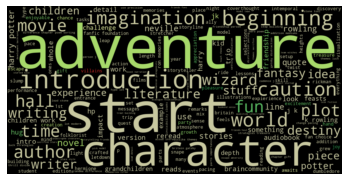

invisibility cloaks first jk book fun
j.k. rowlings imagination
harry potter series
introduction harry
first potter book
audiobook version
other characters
not literature
children works

best 485 

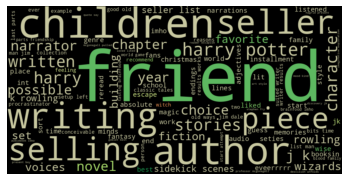

best harry other conceivable
not liked book)it series
audio books harry potter
imaginative exploration
first harry potter book
jk first harry potter
professor mcgonagall
not writing style

love 353 

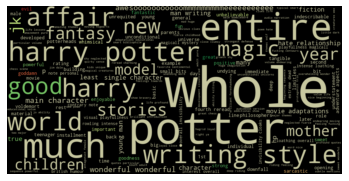

understatement about my feelings towards series
hagrid loyal close clumsy harry philosophers
particular volume endearing moving hogwarts
love awesooooooooooommmmmmmmmeeeeeeeeeee
invisibility cloaks first jk book fun
awesooooooooooommmmmmmmmeeeeeeeeeee
strongest defense against evil
growth shy neglected fierce

awesome 145 

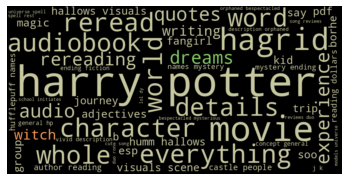

vivid description orphaned bespectacled mysterious
whole harry potter series
whole concept general
harry potter books
lol dy~,books
harry potter
everything

evil 125 

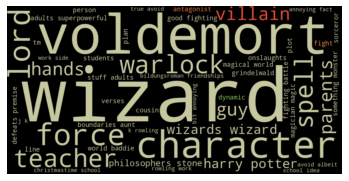

wizard grindelwald
philosophers stone
j.k.rowling work
wizard voldemort
bildungsroman
magical world

perfectly 69 

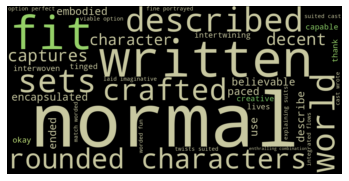

enthralling combination
encapsulated world
rounded characters
imaginative world
decent character
creative story

greatest 60 

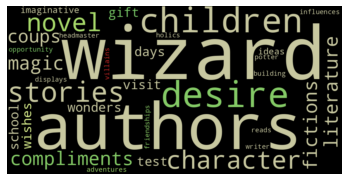

children literature
childrens authors
imaginative ideas
opportunity
friendships

worst 26 

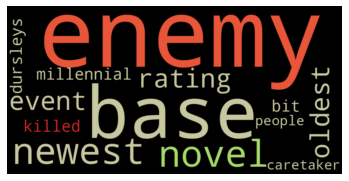

newest rating oldest first
first novel
millennial
caretaker

lovable 21 

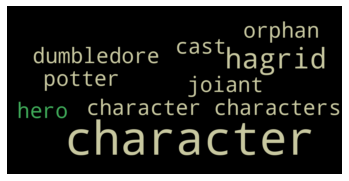

characters
dumbledore
character
orphan

brilliantly 21 

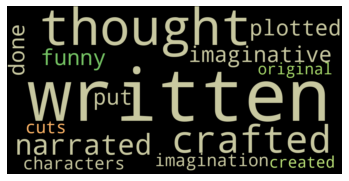

imaginative thought funny
written imagination
characters
written 
 

masterpiece 18 

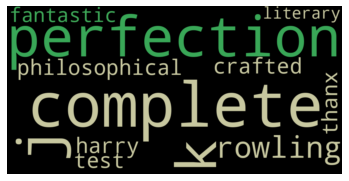

first book harry
philosophical
j. k. rowling
first book

abuse 18 

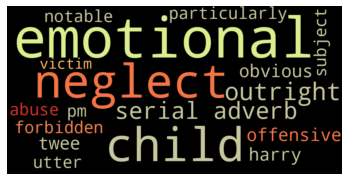

offensive twee serial adverb
abuse utter pm forbidden
not subject emotional
particularly notable

dead 17 

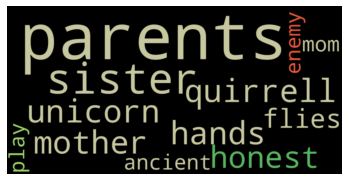

not ancient enemy
mother sister
quirrell
parents

villains 15 

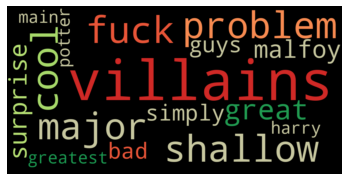

other major problem
simply bad guys
shallow as fuck

superb 14 

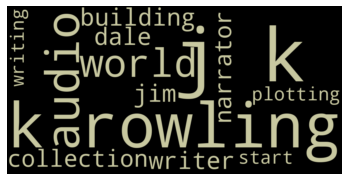

world building
j.k. rowling
j k rowling

outstanding 14 

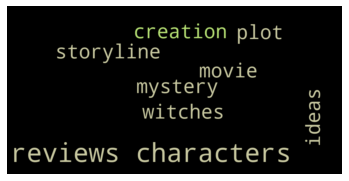

characters
storyline
creation

abusive 13 

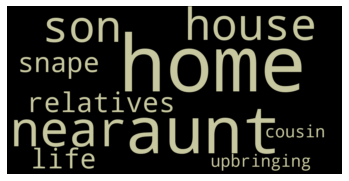

aunt house
upbringing
relatives

devil 11 

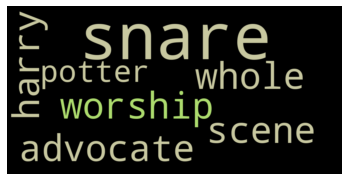

whole harry potter
snare scene
advocate

hatred 10 

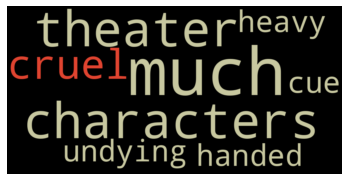

characters
theater
undying

killed 10 

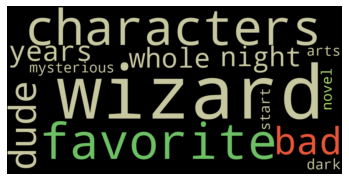

favorite characters
mysterious wizard
arts wizard



In [155]:
forbidden_words = {
    "thing", "things", "one", "way", "part", "deal", "job", "first",
    "book", "books", "serie", "series", "story", "read", "love"
}
print_descriptions(result_dic, min_descs=10, extra_stopwords=forbidden_words)